<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    SAN Projekt:<br> Schweizer Offshore Firmen
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Florin Barbisch, Gabriel Torres Gamez und Tobias Buess im FS 2024.
</p>

Wir führen eine Voranalyse für das Bundesamt für Statistik durch, um die kürzlich aufgetretenen Leaks aus den Offshore Papers zu untersuchen. 

Diese Analyse zielt darauf ab, Umfang und Natur der Verbindungen in Schweizer Offshore-Strukturen zu ermitteln. Wir verwenden dafür Daten aus der [Offshore Leaks Database](https://offshoreleaks.icij.org/), um mögliche Muster, wichtige Personen aufzudecken, die für die Steuerbehörden oder Regulierungsorgane von Interesse sein könnten. 

Unsere Arbeit umfasst eine detaillierte Prüfung der betroffenen Entitäten. Dies wird es dem Bundesamt für Statistik ermöglichen, fundierte Entscheidungen zur weiteren Untersuchung und möglichen Massnahmen zu treffen.

## Imports und Einstellungen

In [1]:
# Python internal modules
import os

# Project modules
import utils

# External modules
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

BACKEND = None  # use default
if "cugraph" in nx.utils.backends.backends.keys():
    import nx_cugraph as nxcg

    BACKEND = "cugraph"

print("Python Environment:")
print(f" | Python version: {os.sys.version}")
print(f" | Numpy version: {np.__version__}")
print(f" | Pandas version: {pd.__version__}")
print(f" | Matplotlib version: {matplotlib.__version__}")
print(f" | NetworkX version: {nx.__version__}")
print(f" | NetworkX backend: {BACKEND}")
print(
    f" | CuGraph version: {nxcg.__version__}"
    if BACKEND == "cugraph"
    else " | CuGraph not installed, for better performance install it like this:\n\tpip install cugraph-cu12 --extra-index-url=https://pypi.ngc.nvidia.com"
)
print()
print("Ressources:")
print(f" | CPU: {os.cpu_count()} cores")

PAPERS = "Pandora Papers"
GRAPH_PATH = f"./data/{PAPERS.lower().replace(' ', '_')}_graph.gexf"

Python Environment:
 | Python version: 3.11.9 (main, May  9 2024, 10:22:36) [GCC 11.4.0]
 | Numpy version: 1.26.4
 | Pandas version: 2.2.2
 | Matplotlib version: 3.8.4
 | NetworkX version: 3.3
 | NetworkX backend: cugraph
 | CuGraph version: 24.04.00

Ressources:
 | CPU: 32 cores


# Daten laden

In [2]:
# Graph mit allen Nodes/Edges von den gewählten Papers laden
G = utils.get_graph(GRAPH_PATH, PAPERS)

# Subgraph mit allen Nodes/Edges von Connected Components welche mindestens 1 Schweizer Adresse beinhalten
#G = utils.filter_graph_by_country_name(G, "Switzerland", verbose=True)

## Is switzerland more involved in offshore companies than other countries?

test hypothesis, maybe using global views of countries and calculating degree centrality

In [3]:
# filter Graph by officers and entities
officer_entity = nx.Graph(G.subgraph(utils.filter_nodes(G, "(node_type == 'Officer') or (node_type == 'Entity')")).to_undirected())

In [4]:
np.unique(list(nx.get_node_attributes(officer_entity, "node_type", "-").values()), return_counts=True)

(array(['Entity', 'Officer'], dtype='<U7'), array([29220, 50452]))

In [5]:
officer_nodes = utils.filter_nodes(officer_entity, "node_type == 'Officer'")

# use projection to figure out connection between officers a simple projection is used because the interaction is not important at the moment, select officer nodes only because nx creates empty nodes... I have no idea why :')
officer_officer = nx.Graph(nx.projected_graph(officer_entity, officer_nodes).subgraph(officer_nodes))

#use the first 3 letters of the country codes for the sake of simplicity
nx.set_node_attributes(
    officer_officer, 
    {node:{key:value if key != "country_codes" else value[:3] for key,value in attr.items()} for node, attr in officer_officer.nodes(data=True)}
)

#remove officers with no country code
cc = nx.get_node_attributes(officer_officer, "country_codes")
officer_officer.remove_nodes_from(np.array(list(cc.keys()))[np.array(list(cc.values())) == "nan"])

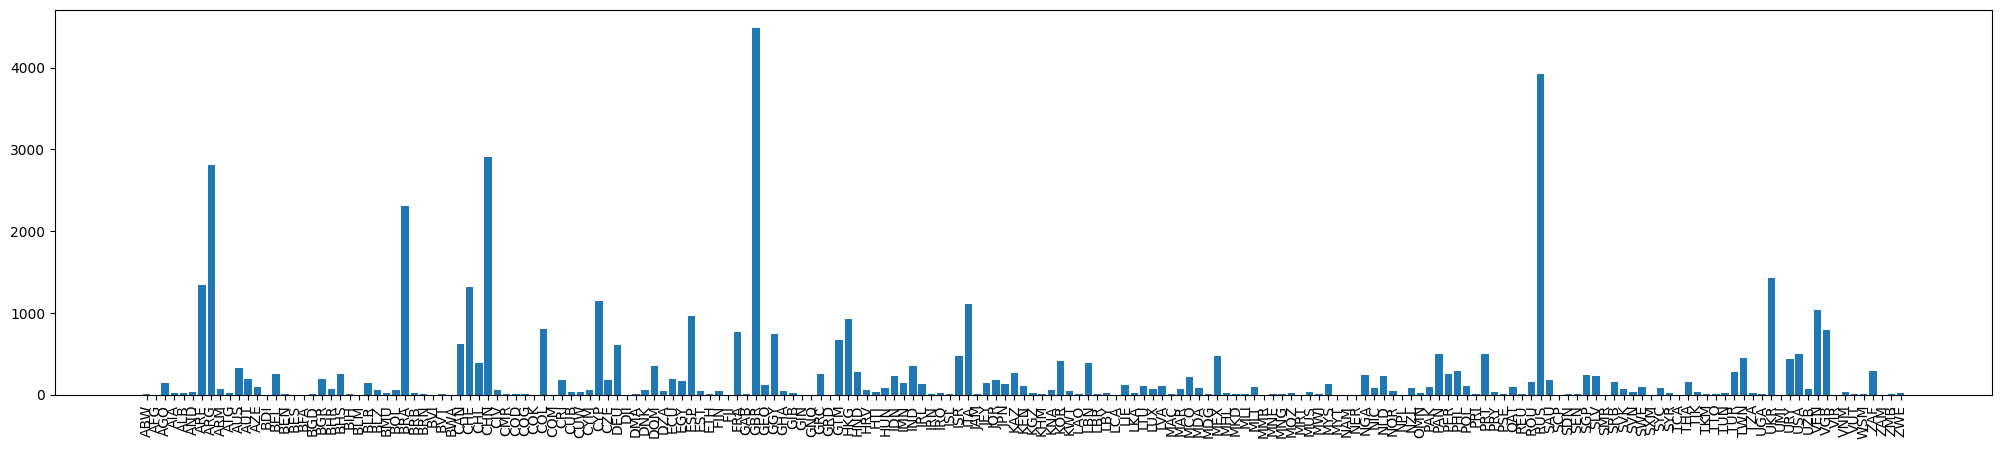

In [6]:
x,y = np.unique([node.get("country_codes", "NA") for node in dict(officer_officer.nodes(data=True)).values()], return_counts=True)

plt.figure(figsize=(25,5))
plt.bar(x, y)
plt.xticks(rotation=90)
plt.show()

In [7]:
original = utils.get_degree_by_country_code_parallel(officer_officer)

mixed = []
for _ in range(2):
    random_graph = utils.create_random_edges_from(officer_officer)
    mixed.append(utils.get_degree_by_country_code_parallel(random_graph))